In [ ]:
model_names = ["gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024","gpt_sw3_356m"]

layer = "transformer.h.15.ln_1.bias"
for model_name in model_names:
    
    model_path = "downloaded_models/"

    model, tokenizer, device = model_setup(f"{model_path}{model_name}")
    
    steering = torch.load(f"steering_vectors/{model_name}/combined_steering_vector_layer_15_tensor.pt",map_location = device)
    
    model.state_dict()[layer] += steering
    
    model.save_pretrained(f'{model_path}/{model_name}_with_steering')
    tokenizer.save_pretrained(f'{model_path}/{model_name}_with_steering')  # Optional but recommended

In [1]:
from refactor.probes import model_setup
import os
from scipy.spatial.distance import euclidean, mahalanobis, cosine
from sklearn.metrics.pairwise import cosine_similarity
import torch
from refactor.utils.hooking import HookManager
from refactor.utils.compatibility import HookAddress

# loads model
print("Load model")
model_name = "EleutherAI/pythia-14m"
model, tokenizer, device = model_setup(model_name)


Load model
found device: cpu


In [2]:
average_vectors = dict()
path = "average_activation_vectors/pythia_14m"
layer = 3
for file in os.listdir(path):
    split = file.split("_")
    language = split[1]
    layer_temp = split[3]
    if int(layer_temp) == layer:
        average_vectors[language] = torch.load(path + "/" + file)

/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_10181/3591045885.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  average_vectors[language] = torch.load(path +

In [3]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."
text = "Tamkatten (Felis catus[1][2] eller Felis silvestris catus[3]) er et lille, tæmmet, kødædende pattedyr oftest med pels. Den kaldes huskat eller bare kat, når der ikke er grund til at skelne den fra andre kattedyr. Katten er værdsat af mennesker for dens selskab og evne til at jage mus og rotter. Mange huskatte bliver op mod 20 år gamle."
if tokenizer.pad_token == None:
    tokenizer.pad_token = tokenizer.eos_token

with HookManager(model) as hook_manager:
    extracted = hook_manager.extract(HookAddress.attention_pre.layer(layer))
    
    tokenized = tokenizer(
                    text,
                    padding=True,
                    truncation=True,
                    return_tensors='pt'
                ).to(device)

    out = model(**tokenized)
    del out

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [4]:
li = []
import torch.nn.functional as F

for token, token_activation in zip(tokenized["input_ids"][0],extracted[0]):
    token_as_word = tokenizer.decode(token).strip()
    #print(token_activation)
    current_max_similarity = 0
    most_similar_language = None
    for language, average_activation in average_vectors.items():
        similarity = cos_sim = F.cosine_similarity(average_activation.unsqueeze(0), token_activation.unsqueeze(0))

        if current_max_similarity < similarity:
            current_max_similarity = similarity
            most_similar_language = language
    li.append((current_max_similarity,most_similar_language, token_as_word))
        
input_text = li       

/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_10181/1901113052.py:54: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((x, y-0.25), word_width, 0.5,


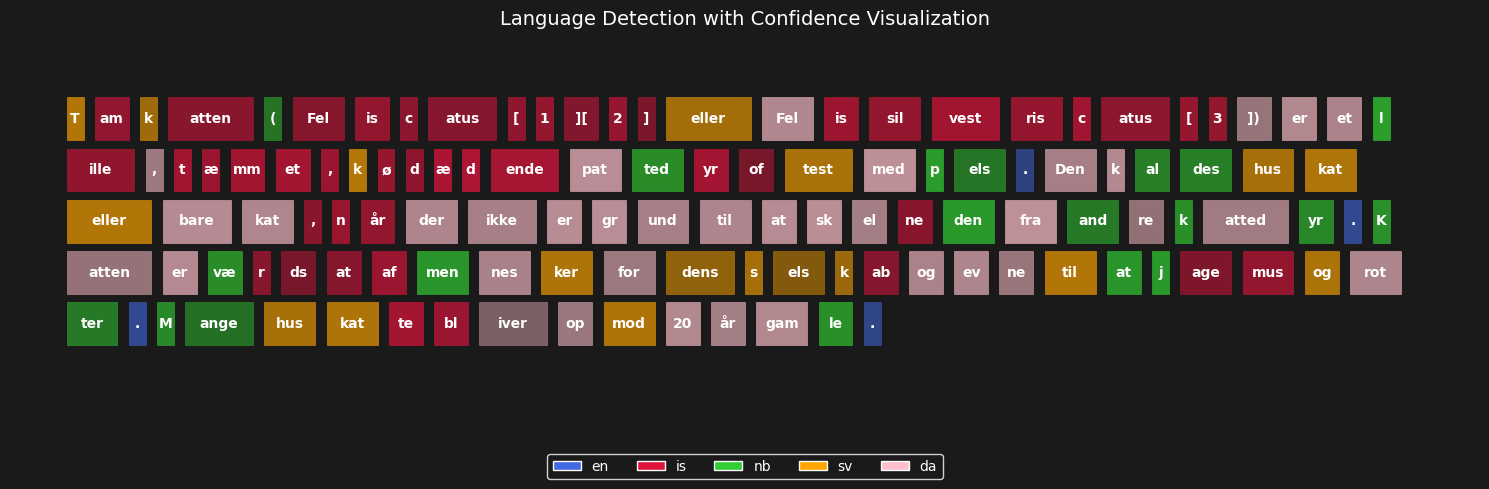

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Parse the input data

# Extract the tensor values and language codes
# For actual code, we need to handle the tensor objects properly
# Here I'll assume tensor([x]) is just a wrapper and we'll extract x
values = [float(str(t[0]).strip('tensor([])')) for t in input_text]
languages = [t[1] for t in input_text]
words = [t[2] for t in input_text]

# Define colors for each language
language_colors = {
    'en': 'royalblue',
    'is': 'crimson',
    'nb': 'limegreen',
    'sv': 'orange',
    "da": "pink"
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_facecolor('#1a1a1a')  # Dark background
ax.set_facecolor('#1a1a1a')

# Turn off axes
ax.axis('off')

# Define the maximum width and height for the visualization
max_width = 12
line_height = 0.6
x, y = 0, 0

# Define a function to get color with alpha based on confidence
def get_color_with_alpha(language, confidence):
    base_color = language_colors.get(language, 'gray')
    # Use the confidence as alpha for the color intensity
    return base_color

# Display text with colored backgrounds
for i, (value, lang, word) in enumerate(zip(values, languages, words)):
    # Calculate the width of this word (including space)
    word_width = len(word) * 0.15
    
    # Check if we need to start a new line
    if x + word_width > max_width:
        x = 0
        y -= line_height
    
    # Create a rectangle with color based on language and intensity based on value
    rect = patches.Rectangle((x, y-0.25), word_width, 0.5, 
                             color=get_color_with_alpha(lang, value),
                             alpha=value,  # Use the tensor value as opacity
                             edgecolor='white',
                             linewidth=0.5)
    ax.add_patch(rect)
    
    # Add the word
    ax.text(x + word_width/2, y, word, 
            ha='center', va='center', 
            color='white',
            fontweight='bold',
            fontsize=10)
    
    # Move to the next position
    x += word_width + 0.1

# Create a legend
legend_elements = []
for lang, color in language_colors.items():
    legend_elements.append(patches.Patch(facecolor=color, edgecolor='white', 
                                         label=f'{lang}'))

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=len(language_colors), facecolor='#1a1a1a', edgecolor='white', framealpha=0.8,
          labelcolor='white')

# Set title
ax.set_title('Language Detection with Confidence Visualization', color='white', fontsize=14)

# Set limits to show all content
ax.set_xlim(-0.5, max_width + 0.5)
ax.set_ylim(y-1, 1)

plt.tight_layout()
plt.savefig('language_visualization.png', facecolor='#1a1a1a', dpi=300)
plt.show()